In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.transforms as T
import matplotlib
import matplotlib.pyplot as plt

# MNIST Autoencoder

In [ ]:
transform = T.ToTensor()

mnist_data = torchvision.datasets.MNIST(root='~/torch_datasets', train=True, download=True, transform=transform)

In [ ]:
data_loader = torch.utils.data.DataLoader(
    dataset=mnist_data,
    batch_size=64,
    shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    # N, 1, 28, 28
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
        nn.ReLU(),
        nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
    )

     # N, 64, 1, 1
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # -> N, 16, 14, 14
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # -> N, 1, 28, 28
        nn.Sigmoid() # To get values between 0 and 1 (our original range)
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Note: T.ToTensor() -> [0, 1] -> nn.Sigmoid
# Note: T.Compose([T.ToTensor(), T.Normalize(0.5, 0.5)]) -> [-1, 1] -> nn.Tanh
# nn.MaxPool2d -> nn.MaxUnPool2d

In [ ]:
#  use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder().to(device)

# mean-squared error loss
criterion = nn.MSELoss()

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
#!pip install tensorboard
%load_ext tensorboard
# Writer will output to ./runs/ directory by default
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

num_epochs = 20
outputs = []
for epoch in range(num_epochs):
    loss = 0
    for (img, _) in data_loader:
        # load data to the active device
        img = img.to(device)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        # compute reconstructions
        recon = model(img)
        # compute training reconstruction loss
        train_loss = criterion(recon, img)
        # compute accumulated gradients
        train_loss.backward()
        # perform parameter update based on current gradients
        optimizer.step()
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    # compute the epoch training loss
    loss = loss / len(data_loader)
    # display the epoch training loss
    print(f'epoch : {epoch+1}/{num_epochs}, loss = {loss:.6f}')
    outputs.append((epoch,img,recon))
    writer.add_scalar('loss', loss, epoch+1)
    writer.add_images('recon', recon, epoch+1)
    writer.add_images('img', img, epoch+1)

writer.flush()
writer.close()

In [ ]:
%tensorboard --logdir=runs --load_fast=false --bind_all

In [ ]:
for k in range(0, num_epochs, 4):
  plt.figure(figsize=(9,2))
  plt.gray()
  imgs = outputs[k][1].detach().cpu().numpy()
  recon = outputs[k][2].detach().cpu().numpy()
  for i, item in enumerate(imgs):
    if i >= 9: break
    plt.subplot(2, 9, i+1) # row_length +i +1
    #item = item.reshape(-1, 28, 28) # item: 1, 28, 28 # when using cnn autoencoder, remove this
    plt.imshow(item[0])
  
  for i, item in enumerate(recon):
    if i >= 9: break
    plt.subplot(2, 9, 9+i+1) # row_length +i +1
    #item = item.reshape(-1, 28, 28) # item: 1, 28, 28 # when using cnn autoencoder, remove this
    plt.imshow(item[0])

# WLASL Autoencoder

In [2]:
import cv2 as cv

def video_to_tensor(path, frames_limit=0):
    cap = cv.VideoCapture(path)
    
    height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    num_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    
    frames = torch.FloatTensor(3, num_frames, height, width)
    
    for i in range(num_frames):# while(cap.isOpened()):
        #cap.set(cv.CAP_PROP_POS_FRAMES, i) # to set the video position
        ret, frame = cap.read()
        if ret == False:
            break
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        frame = torch.from_numpy(frame)
        frame = frame.permute(2, 0, 1) # (H x W x C) to (C x H x W)
        frames[:, i, :, :] = frame.float()
    
    cap.release()
    
    if frames_limit == 0: return frames / 255
    
    ##############################
    # Limit the number of frames #
    ##############################
    
    multiplier = num_frames / frames_limit
    selected_frames = [0] * frames_limit
    for i in range(frames_limit):
        selected_frames[i] = (int)(i * multiplier)
    
    limited_frames = torch.FloatTensor(3, frames_limit, height, width)
    
    for i, elem in enumerate(selected_frames):
        limited_frames[:, i, :, :] = frames[:, elem, :, :]
    
    return limited_frames / 255

In [3]:
# Define Dataset class
class WLASLDataset(Dataset):
    """Class to load WLASL videos and labels."""
    
    def __init__(self, csv_file, transforms=None, frames_limit=0):
        """
        Args:
            csv_file (string): The path to the csv_file
            transforms: The transforms to apply to the videos
            frames_limit (int): The number of frames that every video will have
                                0 when I don't need to limit it
        """
        self.dataframe = pd.read_csv(csv_file)
        self.classes = self.dataframe.label.unique().tolist()
        self.transforms = transforms
        self.frames_limit = frames_limit

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        
        video = video_to_tensor(path = self.dataframe.iloc[index].path,
                                frames_limit = self.frames_limit)
        if self.transforms:
            video = self.transforms(video)
        
        label = self.dataframe.iloc[index].label
        label = self.classes.index(label)
        
        return video, label

In [4]:
# Load dataset
dataset = WLASLDataset("./wlasl5.csv", frames_limit=32)

print('elements:',len(dataset))
print('shapes:',dataset[0][0].size())
print('classes:',dataset.classes)

elements: 157
shapes: torch.Size([3, 32, 256, 256])
classes: ['BEFORE', 'BOOK', 'CHAIR', 'COMPUTER', 'DRINK']


In [5]:
# Create training validation
#train_size = int(len(dataset) * 0.15)
#train_size = len(dataset) - val_size
train_size = 128
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(128, 29)

In [6]:
# Create data loaders to load the data in batches
batch_size = 8

train_loader = DataLoader(dataset=train_ds,
                          batch_size=batch_size,
                          shuffle=True)#, num_workers=2, pin_memory=True)

val_loader = DataLoader(dataset=val_ds,
                        batch_size=batch_size*2)#, num_workers=2, pin_memory=True)

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [14]:
class Autoencoder2(nn.Module):
  def __init__(self):
    super().__init__()
    # N, 3, 32, 256, 256
    self.encoder = nn.Sequential(
        nn.Conv3d(3, 16, kernel_size=3, stride=2, padding=1), # -> N, 16, 16, 128, 128
        nn.ReLU(),
        nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1), # -> N, 32, 8, 64, 64
        nn.ReLU(),
        nn.Conv3d(32, 64, 8, padding=1) # -> N, 64, 1, 8, 8
    )

     # N, 64, 1, 1
    self.decoder = nn.Sequential(
        nn.ConvTranspose3d(64, 32, 8, padding=1), # -> N, 32, 8, 64, 64
        nn.ReLU(),
        nn.ConvTranspose3d(32, 16, 3, stride=2, padding=1, output_padding=1), # -> N, 16, 16, 128, 128
        nn.ReLU(),
        nn.ConvTranspose3d(16, 3, 3, stride=2, padding=1, output_padding=1),# N, 3, 32, 256, 256
        nn.Sigmoid() # To get values between 0 and 1 (our original range)
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Note: T.ToTensor() -> [0, 1] -> nn.Sigmoid
# Note: T.Compose([T.ToTensor(), T.Normalize(0.5, 0.5)]) -> [-1, 1] -> nn.Tanh
# nn.MaxPool2d -> nn.MaxUnPool2d

In [15]:
#  use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder2().to(device)

# mean-squared error loss
criterion = nn.MSELoss()

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


cuda


In [17]:
#!pip install tensorboard
%load_ext tensorboard
# Writer will output to ./runs/ directory by default
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

num_epochs = 5
outputs = []
for epoch in range(num_epochs):
    loss = 0
    for (img, _) in train_loader:
        # load data to the active device
        img = img.to(device)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        # compute reconstructions
        recon = model(img)
        # compute training reconstruction loss
        train_loss = criterion(recon, img)
        # compute accumulated gradients
        train_loss.backward()
        # perform parameter update based on current gradients
        optimizer.step()
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    # compute the epoch training loss
    loss = loss / len(train_loader)
    # display the epoch training loss
    print(f'epoch : {epoch+1}/{num_epochs}, loss = {loss:.6f}')
    outputs.append((epoch,img,recon))
    writer.add_scalar('loss', loss, epoch+1)
    #writer.add_images('recon', recon, epoch+1)
    #writer.add_images('img', img, epoch+1)

writer.flush()
writer.close()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
epoch : 1/5, loss = 0.126384
epoch : 2/5, loss = 0.083525
epoch : 3/5, loss = 0.032710
epoch : 4/5, loss = 0.025151
epoch : 5/5, loss = 0.021922


In [21]:
%tensorboard --logdir=runs --load_fast=false --bind_all

Reusing TensorBoard on port 6009 (pid 2417), started 1:24:33 ago. (Use '!kill 2417' to kill it.)

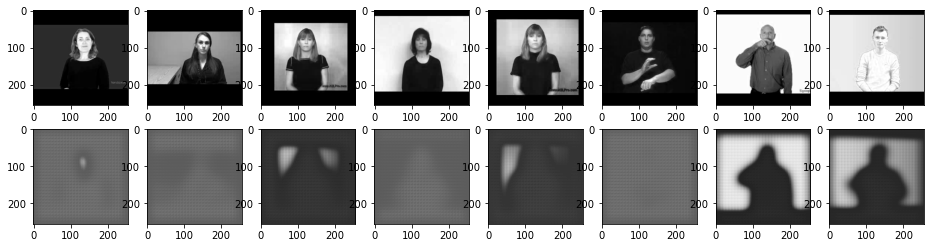

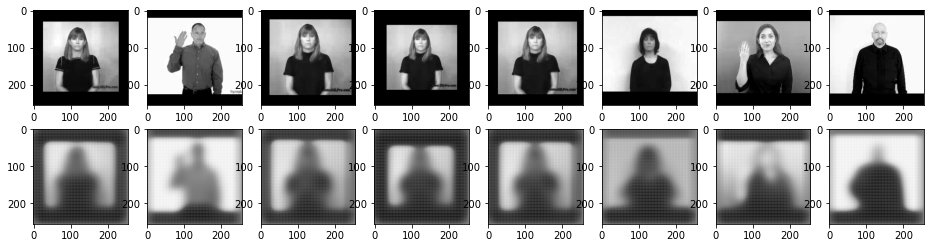

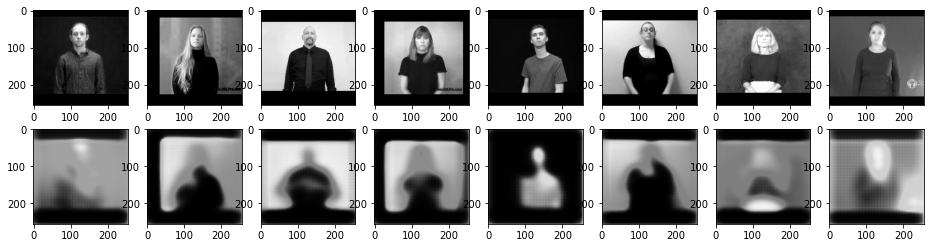

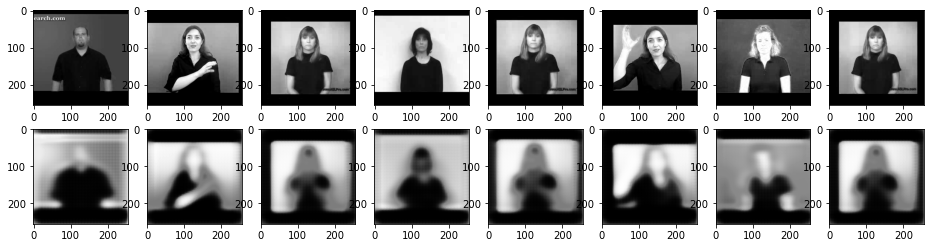

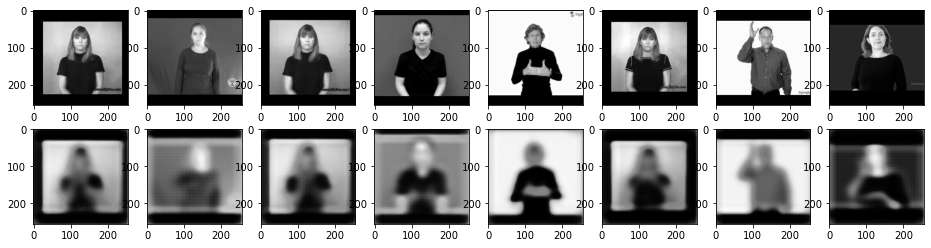

In [25]:
for k in range(0, num_epochs, 1):
  plt.figure(figsize=(18,4))
  plt.gray()
  imgs = outputs[k][1].detach().cpu().numpy()
  recon = outputs[k][2].detach().cpu().numpy()
  for i, item in enumerate(imgs):
    if i >= 9: break
    plt.subplot(2, 9, i+1) # row_length +i +1
    #item = item.reshape(-1, 28, 28) # item: 1, 28, 28 # when using cnn autoencoder, remove this
    plt.imshow(item[0][0])
  
  for i, item in enumerate(recon):
    if i >= 9: break
    plt.subplot(2, 9, 9+i+1) # row_length +i +1
    #item = item.reshape(-1, 28, 28) # item: 1, 28, 28 # when using cnn autoencoder, remove this
    plt.imshow(item[0][0])